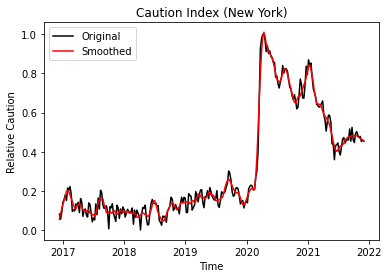

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
#from matplotlib.dates import DateFormatter
#import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import datetime
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank

%matplotlib inline

def mape(actual, fc): 
    actual, fc = np.array(actual), np.array(fc)
    return np.mean(np.abs((actual - fc) / actual)) * 100

def func_exp(t, tau):
    return np.exp(-t / tau)

df1 = pd.read_csv("C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\gtrend_caution.csv") 
df1.head()
df1['date'] = pd.to_datetime(df1.date)
df1.set_index("date", inplace = True)

fig, ax = plt.subplots()
ax.plot(df1.caution,'k-')
ax.set_xlabel("Time")
ax.set_ylabel("Relative Caution")
ax.set_title("Caution Index (New York)")

# Smoothing
df1['caution_sm'] = savgol_filter(df1.caution, window_length = 11, polyorder = 2)
ax.plot(df1.caution_sm,'r-')
ax.legend(['Original','Smoothed'])
plt.show()

df1['caution'] = df1['caution_sm']

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

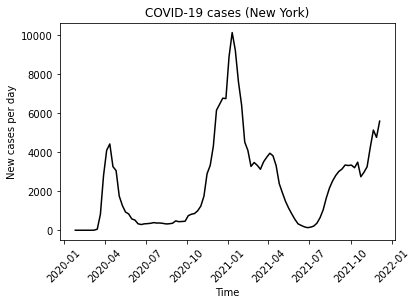

In [534]:
#Read in COVID case numbers

df2 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
df2['submission_date']=pd.to_datetime(df2.submission_date)
df2.set_index('submission_date', inplace = True)
df2 = df2[df2.state=="NY"]
#df2 = df2[df2.state=="CA"]
df2.head()

# Aggregate to weekly
new_cases = df2.new_case.resample('W').mean()

plt.plot(new_cases,'k-')
plt.xlabel('Time')
plt.ylabel('New cases per day')
plt.title('COVID-19 cases (New York)')
plt.xticks(rotation=45)


C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


,temp_C
month_date,
2019-01-20,2.000000
2019-01-27,1.639374
2019-02-03,1.431490
2019-02-10,1.450395
2019-02-17,2.000000
...,...
2022-11-20,9.000000
2022-11-27,9.317951
2022-12-04,8.822310


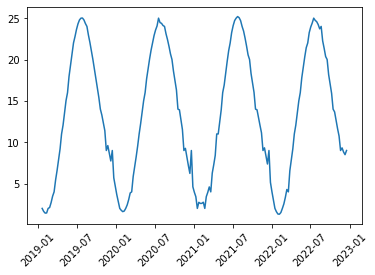

In [535]:
# Repeat average temperature data over several years and interpolate to weeks

df3 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\ny_weather.csv') 
df3['month_date']=pd.to_datetime(df3.month_date)
df3.set_index('month_date', inplace = True)

# Other way
#df3['yyyy'] = pd.to_datetime(df3['month_date']).dt.year
#df3['mm'] = pd.to_datetime(df3['month_date']).dt.month
#df3['dd'] = pd.to_datetime(df3['month_date']).dt.day

#duplicate to multiyear
#df3_copy1 = df3.copy()
#df3_copy1['yyyy'] = df3_copy1['yyyy']-1
#df3_copy1['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy1['yyyy'].astype(str)

#df3_copy2 = df3.copy()
#df3_copy2['yyyy'] = df3_copy2['yyyy']+1
#df3_copy2['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy2['yyyy'].astype(str)

#df3_copy3 = df3.copy()
#df3_copy3['yyyy'] = df3_copy3['yyyy']+2
#df3_copy3['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy3['yyyy'].astype(str)

df3_copy1 = df3.copy()
df3_copy1.index = df3_copy1.index + pd.DateOffset(year=2019)
df3_copy2 = df3.copy()
df3_copy2.index = df3_copy2.index + pd.DateOffset(year=2021)
df3_copy3 = df3.copy()
df3_copy3.index = df3_copy3.index + pd.DateOffset(year=2022)

df3_long = pd.concat([df3_copy1,df3,df3_copy2,df3_copy3],axis=0)
#df3_long['month_date']=pd.to_datetime(df3_long.month_date)
#df3_long.set_index('month_date', inplace = True)

df3_long = df3_long.resample('W').mean().interpolate(method='spline',order=3)

plt.plot(df3_long)
plt.xticks(rotation=45)

df3_long

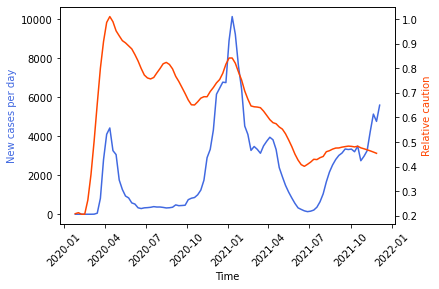

,caution,caution_sm,new_case,temp_C


In [536]:
# Merge the full date range into previous
df_merged = pd.merge(df1,new_cases, how='inner',left_index=True,right_index=True)
df_merged = pd.merge(df_merged,df3_long, how='inner',left_index=True,right_index=True)

# Coplot full range
fig,ax = plt.subplots()
ax.plot(new_cases,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_merged.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

# Subtract baseline "caution" from pre-pandemic and renormalize
df_merged.caution = df_merged.caution-df_merged.caution['2020-01-26':'2020-02-16'].mean()
df_merged.caution = (df_merged.caution-df_merged.caution.min())/(df_merged.caution.max()-df_merged.caution.min())

# Skip initial period of pandemic
df_during = df_merged['2020-04-10':]
# Check for any embedded NaN's that need to be filled
df_during[df_during.caution.isna()==True]

C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


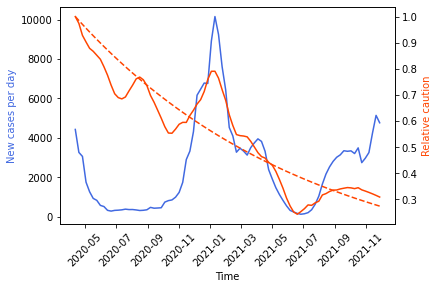

In [537]:
# Coplot 
fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

np.random.seed(0)
t = np.arange(0,len(df_during.caution))
params, cov = curve_fit(func_exp, t, df_during.caution.values)
tau = params
y_fit = func_exp(t, tau)

df_during.loc[:,'caution2'] = df_during.caution-y_fit

ax2.plot(df_during.index, y_fit, color='orangered',linestyle = '--')

plt.show()

#fig.savefig('Caution_and_new_cases.png',
#            format='png',
#            dpi=100,
#            bbox_inches='tight')

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())


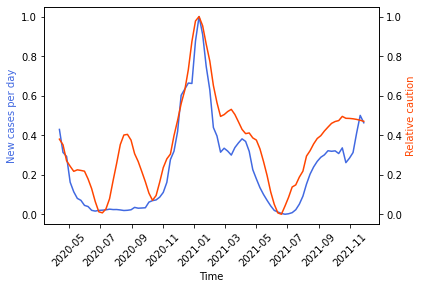

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)


array([[1.        , 0.79519292],
       [0.79519292, 1.        ]])

In [539]:
# Max-min normalize
min_cau = np.min(df_during.caution2)
range_cau = np.max(df_during.caution2)-np.min(df_during.caution2)
df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())

fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)
#ax.plot(df_during.new_case.diff(),color='black')

ax2 = ax.twinx()
ax2.plot(df_during.caution2,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

epsilon = 0.01  # Prevent -inf
df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)

np.corrcoef(df_during.log_caution, df_during.log_new_case)

In [540]:
print(sm.tsa.stattools.adfuller(df_during.caution2))
print(sm.tsa.stattools.adfuller(df_during.new_case))

# One round of differencing makes stationary
print(sm.tsa.stattools.adfuller(df_during.caution.diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().dropna()))

# Log transform also works
print(sm.tsa.stattools.adfuller(df_during.log_caution))
print(sm.tsa.stattools.adfuller(df_during.log_new_case))


(-2.2160987620139925, 0.2004545044060378, 9, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, -329.79882457868416)
(-2.1408716722765755, 0.22840050660386335, 1, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, -224.2073270915622)
(-3.436870064817821, 0.009764378072376909, 8, 76, {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}, -458.81192529594705)
(-5.12617783308809, 1.2415723706919786e-05, 0, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, -217.29635760126746)
(-2.7289189542360175, 0.06916631530496035, 2, 83, {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}, 21.10161040438203)
(-3.076627327456718, 0.028331922005594215, 2, 83, {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}, -52.39264297525543)


In [542]:
grangercausalitytests(df_during[['log_caution','log_new_case']],maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9052  , p=0.1713  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=1.9749  , p=0.1599  , df=1
likelihood ratio test: chi2=1.9523  , p=0.1623  , df=1
parameter F test:         F=1.9052  , p=0.1713  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.3049 , p=0.0000  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=26.1675 , p=0.0000  , df=2
likelihood ratio test: chi2=22.7795 , p=0.0000  , df=2
parameter F test:         F=12.3049 , p=0.0000  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.7113  , p=0.0001  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=25.2645 , p=0.0000  , df=3
likelihood ratio test: chi2=22.0561 , p=0.0001  , df=3
parameter F test:         F=7.7113  , p=0.0001  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.1668  , p=0.0002  , df_d

{1: ({'ssr_ftest': (1.9051586837505359, 0.17125339603042805, 82.0, 1),
   'ssr_chi2test': (1.9748596112048236, 0.1599329850506613, 1),
   'lrtest': (1.9522672855507324, 0.1623427384865046, 1),
   'params_ftest': (1.9051586837505499, 0.17125339603042586, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (12.304949127453709, 2.2280290064866532e-05, 79.0, 2),
   'ssr_chi2test': (26.167486752053456, 2.078750894720272e-06, 2),
   'lrtest': (22.77954132681836, 1.1310594971719024e-05, 2),
   'params_ftest': (12.304949127453826, 2.228029006486461e-05, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.711253202480978, 0.00014533602316976662, 76.0, 3),
   'ssr_chi2test': (25.26450062391794, 1.3594019140607294e-05, 3),
   'lrtest': (22.05614652082656, 6.349971659359038e-05, 3),
   'params_ftest': (7.711253202480901, 0.00014533602316977833, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [543]:
grangercausalitytests(df_during[['log_new_case','log_caution']],maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1074  , p=0.0817  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=3.2211  , p=0.0727  , df=1
likelihood ratio test: chi2=3.1616  , p=0.0754  , df=1
parameter F test:         F=3.1074  , p=0.0817  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8639  , p=0.0102  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=10.3435 , p=0.0057  , df=2
likelihood ratio test: chi2=9.7545  , p=0.0076  , df=2
parameter F test:         F=4.8639  , p=0.0102  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6596  , p=0.0542  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=8.7137  , p=0.0334  , df=3
likelihood ratio test: chi2=8.2860  , p=0.0405  , df=3
parameter F test:         F=2.6596  , p=0.0542  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1016  , p=0.0893  , df_d

{1: ({'ssr_ftest': (3.1074173325548085, 0.08166235402894213, 82.0, 1),
   'ssr_chi2test': (3.2211033325263254, 0.07269461631338181, 1),
   'lrtest': (3.161570300467247, 0.07539063294282126, 1),
   'params_ftest': (3.1074173325547596, 0.08166235402894452, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.863891163322425, 0.010183916871812616, 79.0, 2),
   'ssr_chi2test': (10.343464752381864, 0.005674729532675084, 2),
   'lrtest': (9.754517183607334, 0.007617869117196181, 2),
   'params_ftest': (4.863891163322467, 0.010183916871812216, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.659599683205894, 0.054155721150439734, 76.0, 3),
   'ssr_chi2test': (8.713688435766677, 0.0333500028717915, 3),
   'lrtest': (8.285975858041695, 0.04045679030884618, 3),
   'params_ftest': (2.659599683205896, 0.05415572115043946, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [544]:
result = coint(df_during.new_case, df_during.caution)
result

(-2.0142191554131683,
 0.5211792062490717,
 array([-4.0299263 , -3.40895789, -3.09472294]))

In [545]:
result = coint(df_during.new_case, df_during.caution2)
result

(-4.125218623036076,
 0.004721947265089698,
 array([-4.0299263 , -3.40895789, -3.09472294]))

Text(0.5, 1.0, 'New case')

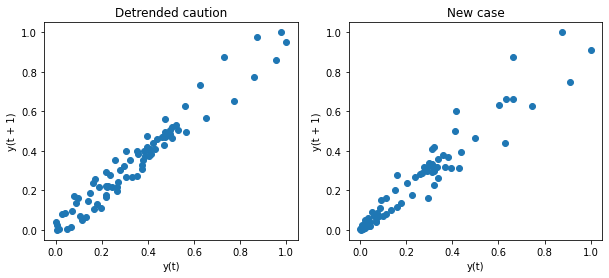

In [546]:
fig_lag, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.caution2,ax=ax1)
ax1.set_title('Detrended caution')
pd.plotting.lag_plot(df_during.new_case,ax=ax2)
ax2.set_title('New case')

Text(0.5, 1.0, 'Log(new cases)')

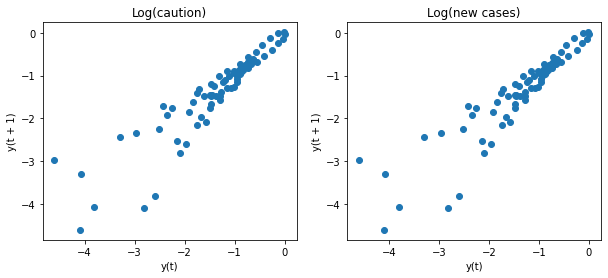

In [547]:
fig_lag_log, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.log_caution,ax=ax1)
ax1.set_title('Log(caution)')
pd.plotting.lag_plot(df_during.log_caution,ax=ax2)
ax2.set_title('Log(new cases)')

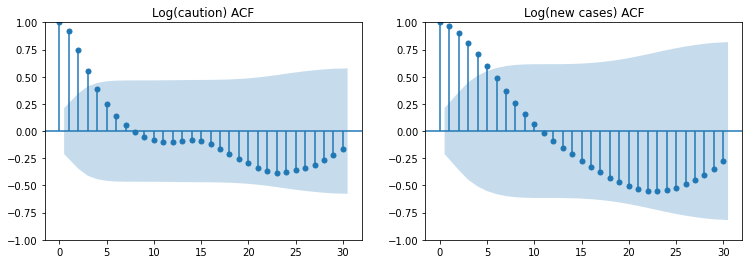

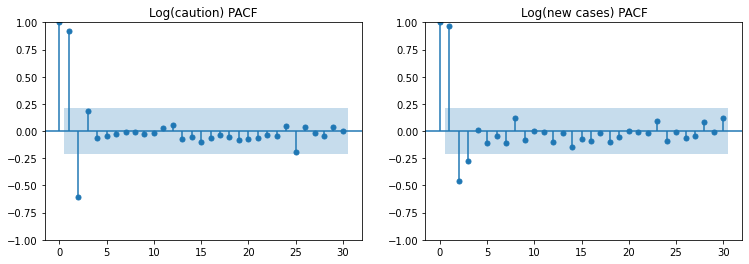

In [548]:
fig_acf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_acf(df_during.log_caution, lags = 30, ax = ax1)
ax1.set_title('Log(caution) ACF')
plot_acf(df_during.log_new_case, lags = 30, ax = ax2)
ax2.set_title('Log(new cases) ACF')
plt.show()

fig_pacf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_pacf(df_during.log_caution, lags = 30, ax = ax1, method='ywm')
ax1.set_title('Log(caution) PACF')
plot_pacf(df_during.log_new_case, lags = 30, ax = ax2, method='ywm')
ax2.set_title('Log(new cases) PACF')
plt.show()

In [549]:
df_sub = df_during[['new_case','caution2']]
train, test = df_sub[0:round(0.8*(len(df_sub.caution2)))], df_sub[round(0.8*(len(df_sub.caution2))):]

rank = select_coint_rank(train, det_order=0, k_ar_diff=3, method='maxeig', signif=0.05)

rank.summary()
# not quite


r_0,r_1,test statistic,critical value
0,1,11.02,14.26


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


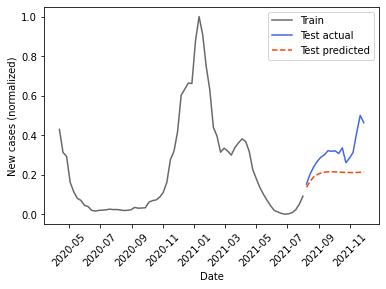

,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.4214,0.114,3.711,0.000,0.199,0.644
L1.caution2,0.3392,0.184,1.843,0.065,-0.022,0.700
L2.new_case,0.0796,0.123,0.648,0.517,-0.161,0.321
L2.caution2,0.3058,0.268,1.141,0.254,-0.219,0.831
L3.new_case,0.0240,0.111,0.217,0.828,-0.193,0.242
L3.caution2,-0.4514,0.192,-2.355,0.019,-0.827,-0.076
,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.0111,0.067,0.165,0.869,-0.120,0.143
L1.caution2,1.0223,0.109,9.402,0.000,0.809,1.235
L2.new_case,0.1096,0.073,1.510,0.131,-0.033,0.252


In [550]:
model_VECM = VECM(train, coint_rank=1, k_ar_diff=3)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=len(test), alpha=0.05)

plt.plot(train.new_case, color='dimgray')
plt.plot(test.new_case, color='royalblue')
plt.plot(test.index,fc_vecm[:,0], color='orangered',linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('New cases (normalized)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

vecm_res.summary()

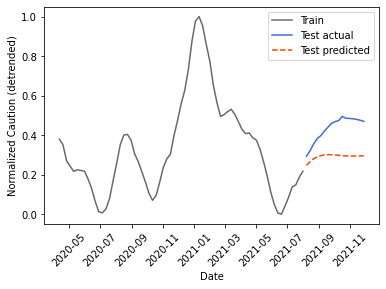

In [552]:
fig,ax = plt.subplots()

ax.plot(train.caution2,color='dimgray')
ax.plot(test.caution2,color='royalblue')
ax.plot(test.index,fc_vecm[:,1],color='orangered',linestyle='--')

ax.set_ylabel('Normalized Caution (detrended)')
ax.set_xlabel('Date')
ax.legend(['Train','Test actual','Test predicted'])

plt.xticks(rotation=45)
plt.show()

In [556]:
# Create date index for next 6 weeks

L=6
i=0
fc_ind = [None]*(L+1)
fc_ind[0]=df_sub.index[-1]
while i<L:
    fc_ind[i+1] = fc_ind[i] + pd.Timedelta(days=7)
    i+=1


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


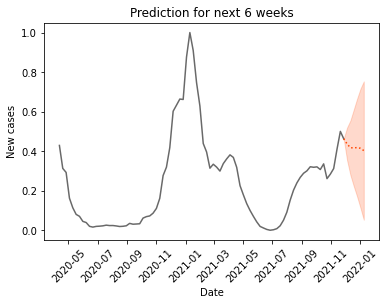

In [557]:
model_VECM = VECM(df_sub, coint_rank=1, k_ar_diff=3, dates=df_sub.index)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=L, alpha=0.05)

plt.plot(df_sub.new_case,color='dimgray')
plt.plot(fc_ind,np.insert(fc_vecm[:,0],0,df_sub.new_case.values[-1]),color='orangered',linestyle=':')

plt.fill_between(fc_ind,
                 np.insert(lower[:,0],0,df_sub.new_case.values[-1]),
                 np.insert(upper[:,0],0,df_sub.new_case.values[-1]),
                 color='orangered',alpha=0.2)

plt.ylabel('New cases')
plt.xlabel('Date')
plt.title('Prediction for next 6 weeks')

plt.xticks(rotation=45)
plt.show()


In [559]:
err_nc = [None]*(3)
err_nc_naive = [None]*3
err_cau = [None]*(3)
err_cau_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):
    train, test = df_sub[0:round(frac_train*(len(df_sub.caution2)))], df_sub[round(frac_train*(len(df_sub.caution2))):]
    
    model_VECM = VECM(train, coint_rank=1, k_ar_diff=3)
    vecm_res = model_VECM.fit()

    fc_vecm = vecm_res.predict(steps=fc_weeks)
    
    err_nc[i] = mape(test.new_case.values[:fc_weeks], fc_vecm[:,0])
    new_case_naive[0:fc_weeks] = np.repeat(test.new_case.values[0],fc_weeks)
    err_nc_naive[i] = mape(test.new_case.values[:fc_weeks],new_case_naive)
    
    err_cau[i] = mape(test.caution2.values[:fc_weeks], fc_vecm[:,1])
    new_case_naive[0:fc_weeks] = np.repeat(test.caution2.values[0],fc_weeks)
    err_cau_naive[i] = mape(test.caution2.values[:fc_weeks],new_case_naive)
    
    i+=1
    
print('Mean VECM new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc))
print('Mean Naive new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc_naive))

print('Mean VECM caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau))
print('Mean Naive caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau_naive))


Mean VECM new case 6 week MAPE error: 10.377092344395576
Mean Naive new case 6 week MAPE error: 16.000932197597596
Mean VECM caution 6 week MAPE error: 10.026706902995345
Mean Naive caution 6 week MAPE error: 10.070064243323605


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [560]:
test.caution2

2021-10-03    0.469068
2021-10-10    0.473790
2021-10-17    0.494928
2021-10-24    0.485369
2021-10-31    0.484724
2021-11-07    0.482847
2021-11-14    0.479741
2021-11-21    0.475409
2021-11-28    0.469852
Name: caution2, dtype: float64

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.164, Time=0.30 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=42.158, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=40.038, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.295, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=158.461, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=38.602, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=38.909, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=42.419, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47.447, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.356, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.872, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=129.242, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=37.944, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=148.636, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=39.477, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             :

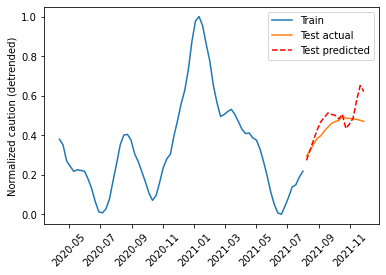

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -18.446
Date:                Thu, 09 Dec 2021   AIC                             44.893
Time:                        14:23:14   BIC                             53.829
Sample:                             0   HQIC                            48.438
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6172      0.048     12.813      0.000       0.523       0.712
ar.L1          1.2373      0.078     15.959      0.000       1.085       1.389
ar.L2         -0.5636      0.076     -7.455      0.000      -0.712      -0.415
sigma2         0.0974      0.010      9.865      0.000       0.078       0.117
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               147.25
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.02
Prob(H) (two-sided):                  0.38   Kurtosis:                        10.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [561]:
df_log = df_during[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_during.log_caution)))], df_log[round(0.8*(len(df_during.log_caution))):]

model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')

model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.log_new_case.values,(-1,1)), n_periods=len(test))

forecast = pd.DataFrame(forecast,index = test.index,columns=['log_caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(np.exp(train.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution_pred)-epsilon, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Normalized caution (detrended)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

model.summary()


In [564]:
err = [None]*(3)
err_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):    
    df_log = df_during[['log_new_case','log_caution']]
    train, test = df_log[0:round(frac_train*(len(df_during.log_caution)))], df_log[round(frac_train*(len(df_during.log_caution))):]

    model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')
    res = model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))

    fc = model.predict(exogenous=np.reshape(test.log_new_case.values[:fc_weeks],(-1,1)), n_periods=fc_weeks)
    
    err[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(fc)-epsilon)
    new_case_naive[0:fc_weeks] = np.repeat(test.log_caution.values[0],fc_weeks)
    err_naive[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(new_case_naive)-epsilon)
    i+=1
    
print('Mean ARMAX',str(fc_weeks),'week error:', np.mean(err))
print('Mean Naive',str(fc_weeks),'week error:', np.mean(err_naive))

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.164, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=42.158, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=40.038, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.295, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=158.461, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=38.602, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=38.909, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=42.419, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47.447, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.356, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.872, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=129.242, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=37.944, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=148.636, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=39.477, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             :

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.164, Time=0.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=42.158, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=40.038, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.295, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=158.461, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=38.602, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=38.909, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=42.419, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47.447, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.356, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.872, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=129.242, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=37.944, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=148.636, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=39.477, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             :

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.164, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=42.158, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=40.038, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.295, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=158.461, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=38.602, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=38.909, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=42.419, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47.447, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.356, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.872, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=129.242, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=37.944, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=148.636, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=39.477, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0]             :

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


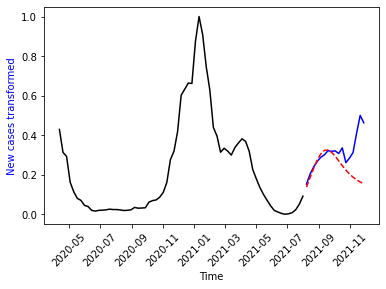

Dep. Variable:,"['log_new_case', 'log_caution']",No. Observations:,69
Model:,VAR(2),Log Likelihood,10.530
,+ intercept,AIC,4.939
Date:,"Thu, 09 Dec 2021",BIC,33.983
Time:,14:30:57,HQIC,16.462
Sample:,04-12-2020,,
,- 08-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"2.15, 0.22",Jarque-Bera (JB):,"0.51, 303.94"
Prob(Q):,"0.14, 0.64",Prob(JB):,"0.78, 0.00"
Heteroskedasticity (H):,"0.36, 2.36",Skew:,"-0.18, 1.02"


In [585]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_log = df_during2[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_log.log_caution)))], df_during[round(0.8*(len(df_log.log_caution))):]
temp_train, temp_test = df_during2.temp_C[0:round(0.8*(len(df_log.log_caution)))], df_during2.temp_C[round(0.8*(len(df_log.log_caution))):]

#model2 = sm.tsa.VARMAX(endog=train, exog=temp_train, order=(2,0), trend='c')
# Temperature coefficient wasn't significant for FL, seemed to overweight winter surge of 2020 for NY
model2 = sm.tsa.VARMAX(endog=train, order = (2,0), trend='c')
model2_fit = model2.fit(maxiter=5000, disp=True)

# Only can forecast from end of sample
fc = model2_fit.forecast(steps=len(test.log_new_case))

fig,ax = plt.subplots()

ax.plot(np.exp(train.log_new_case)-epsilon,color='black')

ax.plot(np.exp(test.log_new_case)-epsilon,color='blue')
ax.set_ylabel('New cases transformed',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_new_case)-epsilon,color='red',linestyle='--')
plt.show()

model2_fit.summary()

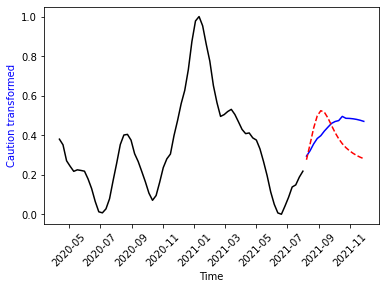

In [586]:
fig,ax = plt.subplots()

ax.plot(np.exp(train.log_caution)-epsilon,color='black')

ax.plot(np.exp(test.log_caution)-epsilon,color='blue')
ax.set_ylabel('Relative caution',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_caution)-epsilon,color='red',linestyle='--')
plt.show()

(-5.12617783308809,
 1.2415723706919786e-05,
 0,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 -217.29635760126746)

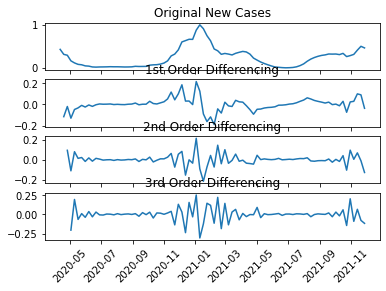

In [601]:
# Make stationary with differencing

fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.new_case); axes[0].set_title('Original New Cases')

# 1st Differencing
axes[1].plot(df_during.new_case.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.new_case.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.new_case.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.new_case.diff().dropna())
result

df_during['new_case_sta'] = df_during.new_case.diff()

(-3.436870064817821,
 0.009764378072376909,
 8,
 76,
 {'1%': -3.5194805351545413,
  '5%': -2.9003945086747343,
  '10%': -2.5874984279778395},
 -458.81192529594705)

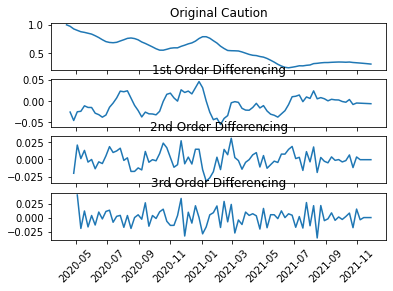

In [600]:
fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.caution); axes[0].set_title('Original Caution')

# 1st Differencing
axes[1].plot(df_during.caution.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.caution.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.caution.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.caution.diff().dropna())
result

df_during['caution_sta'] = df_during.caution.diff()
df_during2 = df_during.dropna()

In [589]:
grangercausalitytests(df_during2[['caution_sta','new_case_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1221  , p=0.7277  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=0.1266  , p=0.7220  , df=1
likelihood ratio test: chi2=0.1265  , p=0.7221  , df=1
parameter F test:         F=0.1221  , p=0.7277  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5527  , p=0.5777  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=1.1762  , p=0.5554  , df=2
likelihood ratio test: chi2=1.1679  , p=0.5577  , df=2
parameter F test:         F=0.5527  , p=0.5777  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1558  , p=0.0296  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=10.3510 , p=0.0158  , df=3
likelihood ratio test: chi2=9.7479  , p=0.0208  , df=3
parameter F test:         F=3.1558  , p=0.0296  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7880  , p=0.1406  , df_d

{1: ({'ssr_ftest': (0.12207036316582402, 0.7277064739121691, 81.0, 1),
   'ssr_chi2test': (0.1265914877275212, 0.7219926143225155, 1),
   'lrtest': (0.12649619414241897, 0.7220929313345865, 1),
   'params_ftest': (0.122070363165888, 0.727706473912092, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5526594773941723, 0.5776539565890505, 78.0, 2),
   'ssr_chi2test': (1.1761727339414436, 0.5553890793542089, 2),
   'lrtest': (1.1679170074716012, 0.5576863877413327, 2),
   'params_ftest': (0.5526594773941753, 0.5776539565890505, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.1557791239991535, 0.029634780153914124, 75.0, 3),
   'ssr_chi2test': (10.350955526717225, 0.015806797911764647, 3),
   'lrtest': (9.747898102219096, 0.020835253720149466, 3),
   'params_ftest': (3.1557791239991437, 0.02963478015391455, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [590]:
grangercausalitytests(df_during2[['new_case_sta','caution_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6385 , p=0.0003  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=15.1807 , p=0.0001  , df=1
likelihood ratio test: chi2=13.9546 , p=0.0002  , df=1
parameter F test:         F=14.6385 , p=0.0003  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2379  , p=0.0013  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=15.4038 , p=0.0005  , df=2
likelihood ratio test: chi2=14.1298 , p=0.0009  , df=2
parameter F test:         F=7.2379  , p=0.0013  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3392  , p=0.0007  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=20.7925 , p=0.0001  , df=3
likelihood ratio test: chi2=18.5314 , p=0.0003  , df=3
parameter F test:         F=6.3392  , p=0.0007  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2521  , p=0.0009  , df_d

{1: ({'ssr_ftest': (14.638490669879177, 0.00025505950884945413, 81.0, 1),
   'ssr_chi2test': (15.180656990985812, 9.769908858853156e-05, 1),
   'lrtest': (13.954601339638373, 0.00018727870304518197, 1),
   'params_ftest': (14.638490669879184, 0.0002550595088494528, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.237921927029389, 0.0013079335737837378, 78.0, 2),
   'ssr_chi2test': (15.40378256265229, 0.00045197156865048647, 2),
   'lrtest': (14.129806804612144, 0.0008545774665873749, 2),
   'params_ftest': (7.237921927029397, 0.001307933573783731, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.339166030130282, 0.0006870379173784978, 75.0, 3),
   'ssr_chi2test': (20.79246457882732, 0.00011625745862495847, 3),
   'lrtest': (18.53140970723348, 0.0003416876178827801, 3),
   'params_ftest': (6.339166030130289, 0.0006870379173784952, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.

In [636]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_sta = df_during2[['new_case_sta','caution_sta']].dropna()
train, test = df_sta[0:round(0.8*(len(df_sta.caution_sta)))], df_sta[round(0.8*(len(df_sta.caution_sta))):]
print(train.shape, test.shape)

model = auto_arima(df_sta.caution_sta, start_p=2, d=1, start_q=1, exogenous=np.reshape(df_sta.new_case_sta.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
fit_sta = model.fit(train.caution_sta, exogenous=np.reshape(train.new_case_sta.values,(-1,1)))

fit_sta.summary()

(68, 2) (17, 2)


C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-516.328, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-515.392, Time=0.43 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-508.038, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-501.087, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-502.055, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-519.759, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-520.904, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-509.614, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-501.816, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-507.766, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-517.191, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-513.767, Time=0.62 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-521.035, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-509.406, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-523.833, Time=0.33 sec
 ARIMA(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 212.288
Date:                Thu, 09 Dec 2021   AIC                           -410.575
Time:                        15:13:26   BIC                           -395.143
Sample:                             0   HQIC                          -404.469
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.355      0.723      -0.000       0.001
x1            -0.0071      0.015     -0.467      0.641      -0.037       0.023
ar.L1          0.5696      0.176      3.244      0.001       0.225       0.914
ma.L1         -0.3406      0.143     -2.382      0.017      -0.621      -0.060
ma.L2          0.2312      0.145      1.593      0.111      -0.053       0.516
ma.L3         -0.7311      0.089     -8.218      0.000      -0.905      -0.557
sigma2         0.0001   1.62e-05      6.180      0.000    6.84e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.95   Prob(JB):                         0.49
Heteroskedasticity (H):               0.70   Skew:                             0.27
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [637]:
#start = 0
#forecast_input = train.values[start:start+lag_order]
#fc_train = fit_sta.predict(forecast_input, steps=len(train)-start-lag_order)
#df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
#df_fc_train['new_case_sta'] = train.values[start+lag_order:,0]

forecast_input = train.caution_sta.values[-lag_order:]
fc = fit_sta.predict(exogenous=np.reshape(test.new_case_sta.values,(-1,1)), n_periods=len(test))
df_forecast = pd.DataFrame(fc,index=df_sta.index[-len(test):], columns = ['caution_sta_fc'])

df_fc = df_forecast.copy()
df_check = pd.DataFrame()

# De-difference
df_fc['caution_fc'] = df_during2['caution'].iloc[len(train)-1] + df_fc['caution_sta_fc'].cumsum()

# Check   
df_check['caution_check'] = df_during2['caution'].iloc[len(train)-1] + test["caution_sta"].cumsum()
df_check['caution'] = df_during2['caution'].iloc[len(train):]

test['caution_fc']=df_fc['caution_fc']



C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/835410282.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=df_fc['caution_fc']


In [638]:
df_check

,caution_check,caution
2021-08-08,0.316195,0.316195
2021-08-15,0.321419,0.321419
2021-08-22,0.329469,0.329469
2021-08-29,0.334845,0.334845
2021-09-05,0.335321,0.335321
2021-09-12,0.339387,0.339387
2021-09-19,0.342114,0.342114
2021-09-26,0.344588,0.344588
2021-10-03,0.343433,0.343433
2021-10-10,0.340573,0.340573


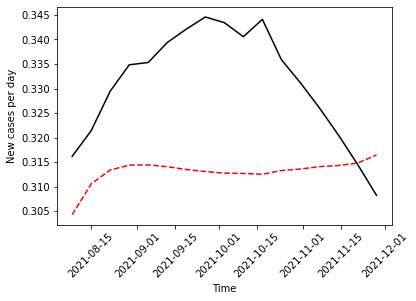

In [639]:
fig,ax = plt.subplots()

ax.plot(df_during2.caution[round(0.8*(len(df_sta.caution_sta))):],color='black')
ax.set_ylabel('New cases per day',color='black')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(test.caution_fc,color='red',linestyle='--')
plt.show()